# Evaluating water mass transformations from finite-volume tracer budget terms

## Import packages

In [1]:
import warnings
import numpy as np
from dask.diagnostics import ProgressBar
import xarray as xr
import xhistogram
import xgcm
from xgcm import Grid
import matplotlib.pyplot as plt

In [2]:
print(
    'numpy version', np.__version__,
    '\nxarray version', xr.__version__,
    '\nxhistogram version', xhistogram.__version__,
    '\nxgcm version', xgcm.__version__
)

numpy version 2.4.2 
xarray version 2026.2.0 
xhistogram version 0.3.2 
xgcm version 0.9.0


In [3]:
import xwmt
print('xwmt version', xwmt.__version__)

xwmt version 0.2.0


## Load datasets and create strucutred grid object

The basic input for `xwmt` is an `xgcm.Grid` object that describes the structure of the underlying ocean model grid. To streamline this example, we use the helper function `load_MOM6_coarsened_diagnostics` to load the data and create the grid object. In later examples, we demonstrate how to build these objects from scratch.

In [4]:
from load_example_model_grid import load_MOM6_coarsened_diagnostics
grid = load_MOM6_coarsened_diagnostics()
display(grid)

File 'MOM6_global_example_sigma2_budgets_v0_0_6.nc' already exists at ../data/MOM6_global_example_sigma2_budgets_v0_0_6.nc. Skipping download.


<xgcm.Grid>
X Axis (periodic, boundary='periodic'):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (not periodic, boundary='extend'):
  * center   yh --> outer
  * outer    yq --> center
Z Axis (not periodic, boundary='extend'):
  * center   sigma2_l --> outer
  * outer    sigma2_i --> center

**Note:** In addition to `grid` containing information about the static model grid, its attribute `grid._ds` points to the full dataset containing model diagnostics!

In [5]:
display(grid._ds)

<xarray.Dataset> Size: 1GB
Dimensions:                         (time_bounds: 2, sigma2_l: 74, yh: 180,
                                     xh: 240, time: 1, xq: 241, yq: 181,
                                     sigma2_i: 75)
Coordinates: (12/28)
  * time_bounds                     (time_bounds) object 16B 2000-01-01 00:00...
    time_bounds_since_init          (time_bounds) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
  * sigma2_l                        (sigma2_l) float64 592B 4.246 ... 38.49
    rho2_l                          (sigma2_l) float64 592B dask.array<chunksize=(74,), meta=np.ndarray>
  * yh                              (yh) int64 1kB 0 1 2 3 4 ... 176 177 178 179
  * xh                              (xh) int64 2kB 0 1 2 3 4 ... 236 237 238 239
    ...                              ...
    geolon_c                        (yq, xq) float64 349kB dask.array<chunksize=(181, 241), meta=np.ndarray>
    geolon_u                        (yh, xq) float64 347kB dask.array<chunksize=(180, 241), meta=np.ndarray>
    wet_u                           (yh, xq) float32 174kB dask.array<chunksize=(180, 241), meta=np.ndarray>
  * yq                              (yq) int64 1kB 0 1 2 3 4 ... 177 178 179 180
  * sigma2_i                        (sigma2_i) float64 600B -3.0 11.49 ... 39.0
    rho2_i                          (sigma2_i) float64 600B dask.array<chunksize=(75,), meta=np.ndarray>
Data variables: (12/46)
    sigma2_bounds                   (time_bounds, sigma2_l, yh, xh) float64 51MB dask.array<chunksize=(2, 74, 180, 240), meta=np.ndarray>
    so_bounds                       (time_bounds, sigma2_l, yh, xh) float32 26MB dask.array<chunksize=(2, 74, 180, 240), meta=np.ndarray>
    thetao_bounds                   (time_bounds, sigma2_l, yh, xh) float32 26MB dask.array<chunksize=(2, 74, 180, 240), meta=np.ndarray>
    thkcello_bounds                 (time_bounds, sigma2_l, yh, xh) float32 26MB dask.array<chunksize=(2, 74, 180, 240), meta=np.ndarray>
    S_advection_xy                  (time, sigma2_l, yh, xh) float64 26MB dask.array<chunksize=(1, 74, 180, 240), meta=np.ndarray>
    Sh_tendency_vert_remap          (time, sigma2_l, yh, xh) float64 26MB dask.array<chunksize=(1, 74, 180, 240), meta=np.ndarray>
    ...                              ...
    umo                             (time, sigma2_l, yh, xq) float64 26MB dask.array<chunksize=(1, 74, 180, 241), meta=np.ndarray>
    vert_remap_h_tendency           (time, sigma2_l, yh, xh) float64 26MB dask.array<chunksize=(1, 74, 180, 240), meta=np.ndarray>
    vmo                             (time, sigma2_l, yq, xh) float64 26MB dask.array<chunksize=(1, 74, 181, 240), meta=np.ndarray>
    vprec                           (time, sigma2_l, yh, xh) float64 26MB dask.array<chunksize=(1, 74, 180, 240), meta=np.ndarray>
    wfo                             (time, sigma2_l, yh, xh) float64 26MB dask.array<chunksize=(1, 74, 180, 240), meta=np.ndarray>
    zos                             (time, yh, xh) float64 346kB dask.array<chunksize=(1, 180, 240), meta=np.ndarray>
Attributes:
    description:  An example netcdf file containing all variables required to...
    version:      0_0_6
    doi:          10.5281/zenodo.15384910

## Part 1. A minimal application of `xwmt`

### Watermass meta data

`xwmt` requires some basic information about water mass properties to compute Water Mass Transformations (WMT) in $\lambda$-coordinates.

In [6]:
metadata_dict = {
    "mass": {"thickness": "thkcello"},
    "heat": {"lambda": "thetao", "surface_lambda": "tos"},
}

### Computing WMTs term by term

To evaluate the WMT for a given term, we simply specify what side of the equation the term belongs on, with the material derivative on the left-hand side (lhs) and non-conservative transformation processes on the right-hand side (rhs), 
\begin{equation}
\rho \frac{\text{D}\lambda}{\text{D}t} = \dot{\Lambda}.
\end{equation}


We construct a dictionary that links each diagnostic variable to a more intuitively named string that describes the process, e.g. `diffusion`.

**Note:** By default, diagnostic tendencies are assumed to be integrated over the mass of each grid cell, i.e. a density-weighted volume integral.

In [7]:
print(f"The variable 'opottempdiff' is the '{grid._ds.opottempdiff.attrs["long_name"]}'")

# Convert vertically-integrated cell heat tendencies into volume-integrated layer tendencies
grid._ds["integrated_diffusive_heat_tendency"] = grid._ds.opottempdiff * grid._ds.areacello
metadata_dict["heat"]["rhs"] = {"diffusion": "integrated_diffusive_heat_tendency"}

The variable 'opottempdiff' is the 'Tendency of sea water potential temperature expressed as heat content due to parameterized dianeutral mixing'


We can then create an instance of the core class `xwmt.WaterMassTransformations`, which inherits some useful methods from it's parent class `xwmt.WaterMass`.

In [8]:
wmt = xwmt.WaterMassTransformations(grid, metadata_dict)

The utility method `WaterMassTransformations.available_processes` searches through the budgets in the metadata dictionary to find all of the processes that are available in the underlying instance of `xarray.Dataset`, which is stored in the grid instance as `grid._ds`.

In [9]:
wmt.available_processes()

['diffusion']

Finally, we can use the `integrate_transformations` method to compute water mass transformations, specifying the desired $\lambda$ key.

In [10]:
with ProgressBar():
    tmp = wmt.integrate_transformations("heat", term="diffusion", bins=np.arange(-3., 35, 0.5)).compute();

[########################################] | 100% Completed | 201.51 ms


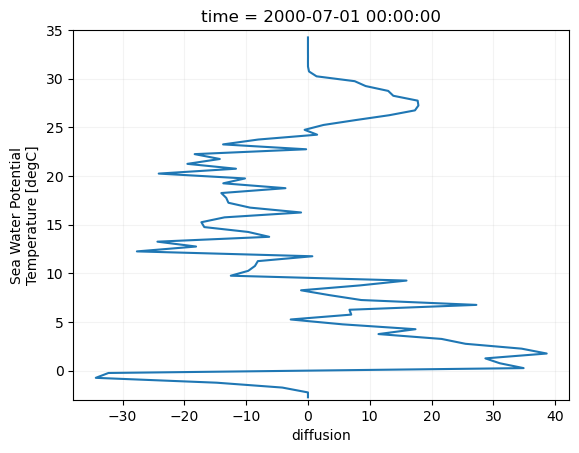

In [11]:
rho0 = 1035.
Sv_per_kgpers = 1e-6/rho0
(tmp['diffusion']*Sv_per_kgpers).plot(y="thetao_l_target")
plt.ylim(-3, 35)
plt.grid(True, alpha=0.15);

In `xwmt`, water mass transformations are defined such that they are positive when they tend to increase the mass of water with tracer values less than the given threshold $\tilde{\lambda}$. For example, $\mathcal{G}^{(Mix)}(\theta = -1^{\circ}\text{C}) \simeq -35$ Sv means that mixing acts to decrease the mass of water that is colder than -1ºC at a rate of about 35 Sv.

## Part 2. Closed and comprehensive water mass transformation budgets

### Comprehensive budget dictionary

Using the optional utility package `xbudget`, we can read in a pre-configured dictionary that contains comprehensive metadata about the structure of tracer budgets in MOM6. (Please feel free to contribute dictionaries for other models!) This dictionary can also be manually created.

In [12]:
import json
import xbudget
print('xbudget version', xbudget.__version__)

budgets_dict = xbudget.load_preset_budget(model="MOM6")
xbudget.collect_budgets(grid, budgets_dict)

print(json.dumps(budgets_dict['heat'], sort_keys=True, indent=4))

xbudget version 0.6.2
{
    "lambda": "thetao",
    "lhs": {
        "sum": {
            "Eulerian_tendency": {
                "product": {
                    "area": "areacello",
                    "tracer_content_tendency_per_unit_area": "opottemptend",
                    "var": "heat_lhs_sum_Eulerian_tendency_product"
                },
                "var": "heat_lhs_sum_Eulerian_tendency"
            },
            "advection": {
                "sum": {
                    "interfacial": {
                        "product": {
                            "area": "areacello",
                            "sign": -1.0,
                            "tracer_content_tendency_per_unit_area": "Th_tendency_vert_remap",
                            "var": "heat_lhs_sum_advection_sum_interfacial_product"
                        },
                        "var": "heat_lhs_sum_advection_sum_interfacial"
                    },
                    "lateral": {
                        "produc

Note how this nested dictionary structure allows diagnostics which are unavailable in the convenient layer-integrated form of our example above to be derived or approximated from other available variables. For example, consider the advective surface ocean heat flux, which is described by the sub-dictionary

```python
            "surface_ocean_flux_advective_negative_rhs": {
                "product": {
                    "area": "areacello",
                    "density": 1035.0,
                    "lambda_mass": "tos",
                    "sign": -1.0,
                    "specific_heat_capacity": 3992.0,
                    "thickness_tendency": "boundary_forcing_h_tendency",
                    "var": "heat_rhs_sum_surface_ocean_flux_advective_negative_rhs_product"
                },
```

This gives `xbudget` instructions on how to reconstruct the `surface_ocean_flux_advective_negative_rhs` tendency as a product of other terms:
\begin{equation}
-\lambda_{m}Q_{m} \text{d}A = (-1)*(c_{p}*\Theta_{m})*\big(\rho_{0}*\big[\frac{\partial h}{\partial t}\big]_{boundary}\big) * \text{d}A
\end{equation}

By calling `xbudget.collect_budgets`, every derived term in the budget is given a standardized name and lazily added to the dataset `grid._ds`. For example, the lazily-calculated term described above is stored as:

In [13]:
grid._ds['heat_rhs_sum_surface_ocean_flux_advective_negative_rhs_product']

<xarray.DataArray 'heat_rhs_sum_surface_ocean_flux_advective_negative_rhs_product' (
                                                                                    time: 1,
                                                                                    yh: 180,
                                                                                    xh: 240,
                                                                                    sigma2_l: 74)> Size: 26MB
dask.array<mul, shape=(1, 180, 240, 74), dtype=float64, chunksize=(1, 180, 240, 74), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 8B 2000-07-01 00:00:00
  * yh         (yh) int64 1kB 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179
  * xh         (xh) int64 2kB 0 1 2 3 4 5 6 7 ... 233 234 235 236 237 238 239
    areacello  (yh, xh) float64 346kB dask.array<chunksize=(180, 240), meta=np.ndarray>
    deptho     (yh, xh) float32 173kB dask.array<chunksize=(180, 240), meta=np.ndarray>
    geolat     (yh, xh) float64 346kB dask.array<chunksize=(180, 240), meta=np.ndarray>
    geolon     (yh, xh) float64 346kB dask.array<chunksize=(180, 240), meta=np.ndarray>
    lat        (yh, xh) float64 346kB dask.array<chunksize=(180, 240), meta=np.ndarray>
    lon        (yh, xh) float64 346kB dask.array<chunksize=(180, 240), meta=np.ndarray>
    wet        (yh, xh) float32 173kB dask.array<chunksize=(180, 240), meta=np.ndarray>
  * sigma2_l   (sigma2_l) float64 592B 4.246 13.57 17.71 ... 37.76 37.9 38.49
    rho2_l     (sigma2_l) float64 592B dask.array<chunksize=(74,), meta=np.ndarray>
Attributes:
    time_avg_info:  average_T1,average_T2,average_DT
    cell_methods:   area:sum yh:sum xh:sum time: point
    long_name:      Ocean Grid-Cell Area
    note:           We ignore land cells in partially wet cells when coarseni...
    units:          m2
    provenance:     [-1.0, 3992.0, 'tos', 'boundary_forcing_h_tendency', 1035...

The full dictionary is daunting, but we don't need every term just to close the water mass transformation budget. We can use the `xbudget.aggregate` function to just pick out the highest-level terms in the budget.

In [14]:
simple_budgets = xbudget.aggregate(budgets_dict)
print(json.dumps(simple_budgets, sort_keys=True, indent=4))

{
    "heat": {
        "lambda": "thetao",
        "lhs": {
            "Eulerian_tendency": "heat_lhs_sum_Eulerian_tendency",
            "advection": "heat_lhs_sum_advection",
            "surface_ocean_flux_advective_negative_lhs": "heat_lhs_sum_surface_ocean_flux_advective_negative_lhs"
        },
        "rhs": {
            "bottom_flux": "heat_rhs_sum_bottom_flux",
            "diffusion": "heat_rhs_sum_diffusion",
            "frazil_ice": "heat_rhs_sum_frazil_ice",
            "surface_exchange_flux": "heat_rhs_sum_surface_exchange_flux",
            "surface_ocean_flux_advective_negative_rhs": "heat_rhs_sum_surface_ocean_flux_advective_negative_rhs"
        },
        "surface_lambda": "tos"
    },
    "mass": {
        "lambda": "density",
        "lhs": {
            "Eulerian_tendency": "mass_lhs_sum_Eulerian_tendency"
        },
        "rhs": {
            "advection": "mass_rhs_sum_advection",
            "surface_exchange_flux": "mass_rhs_sum_surface_exchange_flux"
  

### Redundancy of derived terms

Some terms in the budget, such as the water mass transformation due to surface heat fluxes, can be equivalently derived from two different sets of budget diagnostics:

In [15]:
term = budgets_dict['heat']['rhs']['sum']['surface_exchange_flux']
print("As the product of the layer-integrated convergence of surface heat fluxes, multiplied with the cell area:")
print(json.dumps(term['product'], sort_keys=True, indent=4), end="\n\n")
print("Or as the sum of the individual heat surface heat fluxes\n(where we distinguish advection and non-advective contributions),\neach individually multiplied by the cell area:")
print(json.dumps(term['sum'], sort_keys=True, indent=4))

As the product of the layer-integrated convergence of surface heat fluxes, multiplied with the cell area:
{
    "area": "areacello",
    "tracer_content_tendency_per_unit_area": "boundary_forcing_heat_tendency",
    "var": "heat_rhs_sum_surface_exchange_flux_product"
}

Or as the sum of the individual heat surface heat fluxes
(where we distinguish advection and non-advective contributions),
each individually multiplied by the cell area:
{
    "advective": {
        "product": {
            "area": "areacello",
            "tracer_content_tendency_per_unit_area": "heat_content_surfwater",
            "var": "heat_rhs_sum_surface_exchange_flux_sum_advective_product"
        },
        "var": "heat_rhs_sum_surface_exchange_flux_sum_advective"
    },
    "nonadvective": {
        "sum": {
            "latent": {
                "product": {
                    "area": "areacello",
                    "tracer_content_tendency_per_unit_area": "hflso",
                    "var": "heat_rhs_sum

We can plot these to verify that they are indeed equivalent (to machine precision):

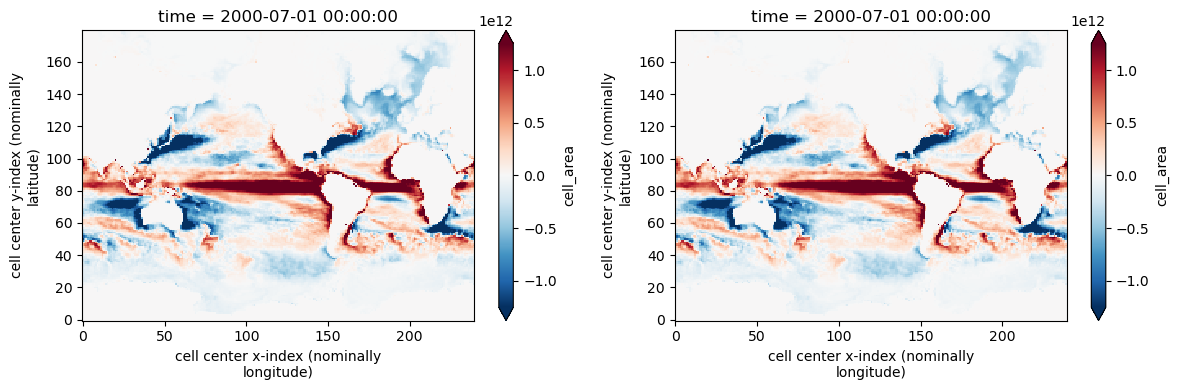

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
grid._ds[term['product']['var']].sum("sigma2_l").plot(robust=True)
plt.subplot(1,2,2)
grid._ds[term['sum']['var']].sum("sigma2_l").plot(robust=True)
plt.tight_layout()

### Compute water mass transformations

Finally, we can create an instance of the core `WaterMassTransformations` class and verify that it can find all of the processes we need in the dataset.

In [17]:
wmt = xwmt.WaterMassTransformations(grid, simple_budgets)
sorted(wmt.available_processes())

['Eulerian_tendency',
 'advection',
 'bottom_flux',
 'diffusion',
 'frazil_ice',
 'surface_exchange_flux',
 'surface_ocean_flux_advective_negative_lhs',
 'surface_ocean_flux_advective_negative_rhs']

We use the `integrate_transformations` method to compute area-integrated water mass transformations in the specified coordinate (e.g. `"heat"`).

In [18]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    kwargs = {"sum_components":True, "group_processes":True}
    G_temperature = wmt.integrate_transformations(
        "heat",
        bins=np.arange(-3, 35, 0.25),
        **kwargs
    ).mean('time')
    G_salinity = wmt.integrate_transformations(
        "salt",
        bins=np.arange(0, 50, 0.25),
        **kwargs
    ).mean('time')
    G_density = wmt.integrate_transformations(
        "sigma0",
        bins=np.arange(0, 40, 0.25),
        **kwargs
    ).mean('time')
    
Gs = [G_temperature, G_salinity, G_density]

Process 'bottom_flux' for component salt is unavailable.
Process 'frazil_ice' for component salt is unavailable.


In [19]:
for G in Gs:
    with ProgressBar():
        G.load()

[########################################] | 100% Completed | 407.05 ms
[########################################] | 100% Completed | 406.28 ms
[########################################] | 100% Completed | 835.86 ms


Finally, we can plot the WMT associated with each of the terms and verify that our water mass transformation budgets close:

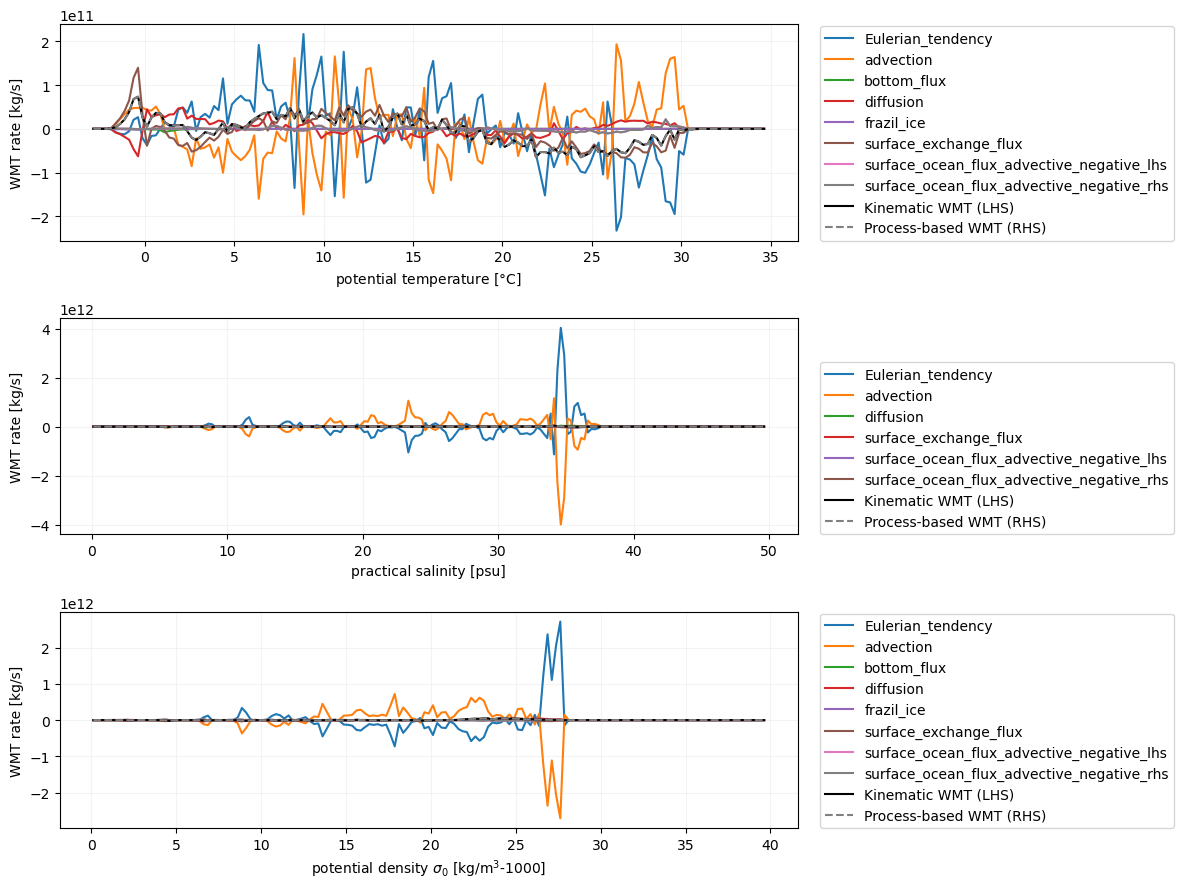

In [20]:
long_names =  [r"potential temperature [$\degree$C]", r"practical salinity [psu]", r"potential density $\sigma_{0}$ [kg/m$^{3}$-1000]"]

plt.figure(figsize=(12, 9))
for i, (G, long_name) in enumerate(zip(Gs, long_names)):
    plt.subplot(3,1,i+1)
    for v in sorted(wmt.available_processes()):
        if v not in G: continue
        G[v].plot(label=v)
    G['kinematic_transformation'].plot(label="Kinematic WMT (LHS)", color="k")
    G['material_transformation'].plot(label="Process-based WMT (RHS)", ls="--", color="grey")
    plt.legend(loc=(1.03, 0.))
    plt.ylabel("WMT rate [kg/s]")
    plt.xlabel(long_name)
    plt.grid(True, alpha=0.15)
plt.tight_layout()

We see that there is a high degree of cancellation between two of the terms on the LHS of the transformation equation: the tendency term and the advection term. In water mass transformation, theory, however, we are more interested in the transformation terms that appear on the RHS of the equation.

## Part 3. Selectively decomposing budget terms

In density coordinates, there seems to be a dominant balance between the diffusive and surface fluxes terms on the RHS.

Let's break those processes down even further to gain a better understanding.

In [21]:
decomposed_budgets = xbudget.aggregate(budgets_dict, decompose=["diffusion", "surface_exchange_flux", "nonadvective"])
wmt = xwmt.WaterMassTransformations(grid, decomposed_budgets)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    G_density = wmt.integrate_transformations(
        "sigma2",
        bins=np.arange(28, 38, 0.2),
        **kwargs
    ).mean('time')
    with ProgressBar():
        G_density.load()

[########################################] | 100% Completed | 815.55 ms


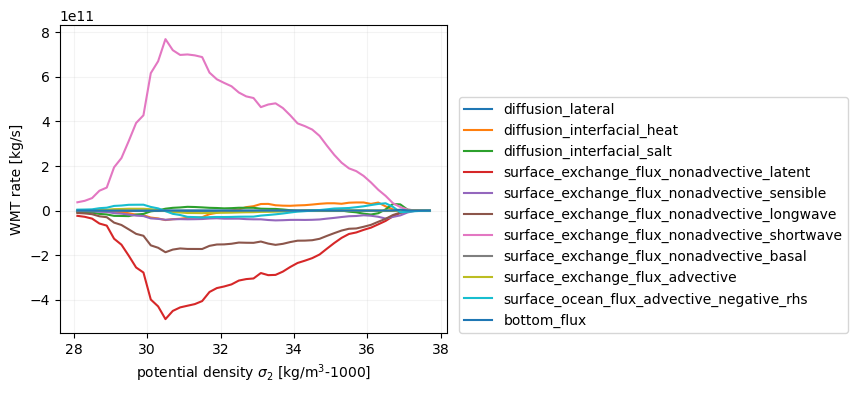

In [22]:
G = G_density
long_name = r"potential density $\sigma_{2}$ [kg/m$^{3}$-1000]"

processes = [
    "diffusion_lateral",
    "diffusion_interfacial_heat",
    "diffusion_interfacial_salt",
    "surface_exchange_flux_nonadvective_latent",
    "surface_exchange_flux_nonadvective_sensible",
    "surface_exchange_flux_nonadvective_longwave",
    "surface_exchange_flux_nonadvective_shortwave",
    "surface_exchange_flux_nonadvective_basal",
    "surface_exchange_flux_advective",
    "surface_ocean_flux_advective_negative_rhs",
    "frazil_heat_tendency",
    "bottom_flux",
]

plt.figure(figsize=(5, 4))
for v in processes:
    if v not in G: continue
    G[v].plot(label=v)
plt.legend(loc=(1.03, 0))
plt.ylabel("WMT rate [kg/s]")
plt.xlabel(long_name)
plt.grid(True, alpha=0.15)

## Part 4: Mapping spatial patterns of water mass transformation

Suppose we are interested in better understanding how surface exchange fluxes drive the formation of dense waters and where these transformations occur spatially.

Instead of `integrate_transformations`, we can use `map_transformations` to compute the transformation in each grid columns.

In [23]:
sigma2_lev = 36.85

wmt = xwmt.WaterMassTransformations(grid, simple_budgets)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    G_density_map = (
        wmt.map_transformations("sigma2", bins=np.arange(28, 38, 0.2))
        .sel(sigma2_l_target=sigma2_lev, method="nearest")
    );
    with ProgressBar():
        G_density_map.load();

[########################################] | 100% Completed | 810.00 ms


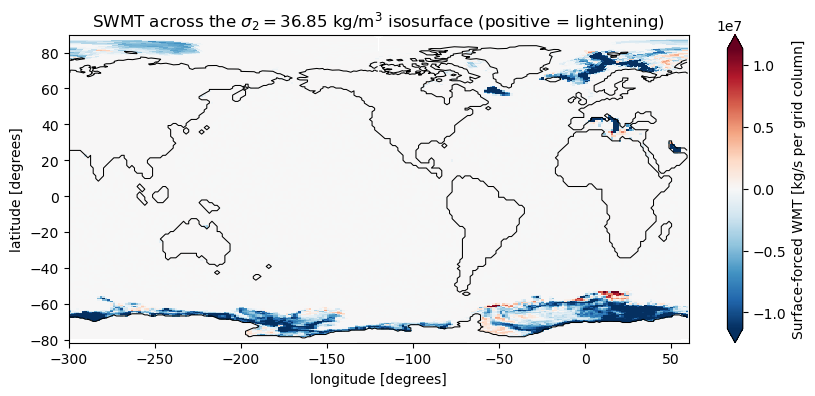

In [24]:
total_surface_forced_flux = (
    G_density_map["surface_exchange_flux"] + # part due to direct fluxes of heat and salt
    G_density_map["surface_ocean_flux_advective_negative_rhs"] # part due to freshwater fluxes that dilute/concentrate salt and temperature
)

plt.figure(figsize=(10, 4))
pc = total_surface_forced_flux.plot(x="geolon", y="geolat", robust=True)
(G_density_map.wet == 0).plot.contour(levels=[0], colors="k", x="geolon", y="geolat", linewidths=0.75)
plt.title("");
plt.xlabel("longitude [degrees]")
plt.ylabel("latitude [degrees]")
pc.colorbar.set_label("Surface-forced WMT [kg/s per grid column]")
plt.title(rf"SWMT across the $\sigma_{{2}} = {sigma2_lev}$ kg/m$^{{3}}$ isosurface (positive = lightening)");